In [2]:
# este notebook fue implementado por Joaquin Zaffaroni Torre
# Para organizacion de Datos en 2018

In [3]:
from matplotlib import pyplot as plt

In [4]:
import matplotlib as mpl
import numpy as np
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}\usepackage{fixmath}'] #for \text command


In [5]:
N = 300
stdev = 0.27
np.random.seed(2)
X, Y = [], []
for mu_x, mu_y in zip([0, 1, 2], [0, 1, 0]):
    X.extend(np.random.randn(N)*stdev+mu_x)
    Y.extend(np.random.randn(N)*stdev+mu_y)

X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((900,), (900,))

In [6]:
from matplotlib.colors import ListedColormap
def plot_clustering(X, Y, clusters, val=None, it=None, lims="fixed"):
    plt.figure(dpi=150)
    if min(clusters) == -1:
        colors = ListedColormap(["#07a6fc", "#5d07fc", "#fc5d07", "#a6fc07"])
        plt.scatter(X, Y, c=clusters, cmap=colors)
        # re-plotear coloreados para que esten visibles
        for x, y, cluster in zip(X,Y,clusters):
            if cluster > -1:
                plt.scatter(x,y,c=colors.colors[cluster+1])
    else:
        colors = ListedColormap(["#5d07fc", "#fc5d07", "#a6fc07"])
        plt.scatter(X, Y, c=clusters, cmap=colors)
    
    if it is not None:
        plt.title(f"Iteración \#{it}")
    
    
    plt.axis('off')
    
    if lims=="fixed":
        lims = ((-1, 2),(-0.8, 2.8))

    plt.xlim(*lims[0])
    plt.ylim(*lims[1])
    
    if val is not None:
        x_text = (lims[0][1]-lims[0][0])*3/10+lims[0][0]
        y_text = lims[1][0]
        plt.text(x_text,y_text, s=r'$$\sum_{i=1}^3 \sum_{\mathbold{x}\in S_i} \left \| '
                             r'\mathbold{x} - \mathbold{\mu}_i \right \| = '
                             fr'{val}$$ ', fontsize=14)
    
    ;


In [7]:
def get_cluster(point, cluster_elements):
    for index, elements in enumerate(cluster_elements):
        if point in elements:
            return index
    return -1

def get_cluster_means(cluster_elements, X, Y):
    mean_vectors = []
    for index, elements in enumerate(cluster_elements):
        
        mean_x = np.mean(X[elements])
        mean_y = np.mean(Y[elements])
        mean_vectors.append(np.array([mean_x, mean_y]))
    return mean_vectors

def get_closest_cluster(cluster_means, x, y):
    return np.argmin([np.linalg.norm(np.array([x,y]) - mean_vector) for mean_vector in cluster_means])

def calculate_modularity(cluster_elements, X, Y):
    modularity = 0
    mean_vectors = get_cluster_means(cluster_elements, X, Y)
    for index, elements in enumerate(cluster_elements):
        mean_vector = mean_vectors[index]
        # stack: transformamos los vectores X e Y a una matriz de forma (N, 2)
        # restamos el vector promedio
        # calculamos la norma de cada punto
        # sumamos todas las normas
        modularity += np.sum(np.linalg.norm(np.stack([X[elements], Y[elements]], axis=1) - mean_vector, axis=1))
        
    return modularity

def get_point_colors(cluster_elements):
    return [get_cluster(point, cluster_elements) for point in range(N*3)]

def construct_cluster_elements(clusters, n_clusters=3):
    cluster_elements = [ [] for _ in range(n_clusters)]
    for point_index, cluster in enumerate(clusters):
        cluster_elements[cluster].append(point_index)
    return cluster_elements

In [8]:
list(range(1,2))

[1]

### Buscar puntos iniciales interesantes

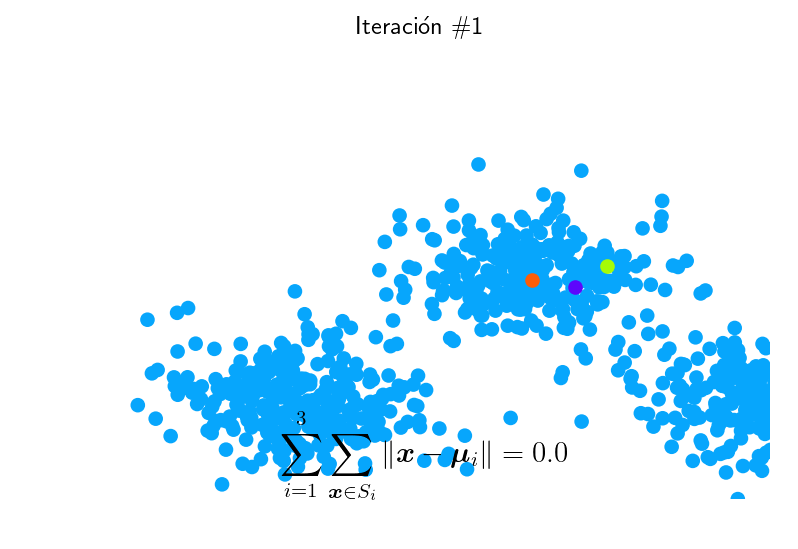

In [9]:
cluster_elements = [[N], [N+1], [N+99]]
colors = get_point_colors(cluster_elements)
plot_clustering(X, Y, colors, calculate_modularity(cluster_elements, X, Y), it="1")

### Crear fotogramas

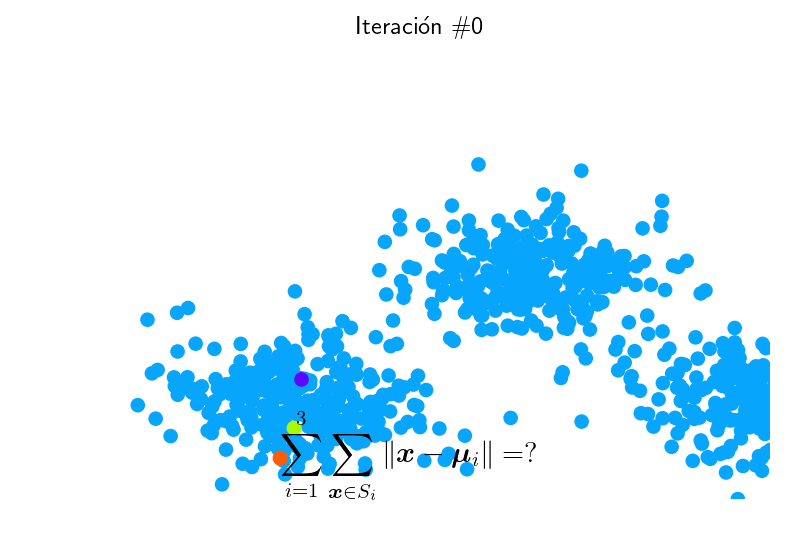

In [10]:
cluster_elements = [[1], [N-1], [N-2]]
colors = get_point_colors(cluster_elements)
plot_clustering(X, Y, colors, "?", it="0")
plt.savefig("0.png", dpi=150)

for it in range(10):
    # Recalcular centroides
    cluster_means = get_cluster_means(cluster_elements, X, Y)
    # Asignar clusters
    colors = [get_closest_cluster(cluster_means, x, y)  for x, y in zip(X,Y)]
    cluster_elements = construct_cluster_elements(colors)
    # Calculamos la modularidad (solo con fin pedagógico)
    modularity = calculate_modularity(cluster_elements, X, Y)
    
    plot_clustering(X, Y, colors, f"{modularity:.2f}", it=str(it+1))
    plt.savefig(f"{it+1}.png", dpi=150)
    plt.close()


### Juntar los fotogramas en un gif

In [11]:
import imageio
from pathlib import Path
images = []
filenames = sorted(list(Path(".").glob("*.png")), key=lambda fn: int(str(fn).split(".")[0]))
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images, duration=1.0)


![Movie](movie.gif)

### Diagrama de elegir K con métrica de modularidad

In [11]:
last_modularity_achieved = []
for k in range (1, 10):
    cluster_elements = [[i] for i in range(k)]
    #print(f"{k}:")
    for it in range(10):
        # Recalcular centroides
        cluster_means = get_cluster_means(cluster_elements, X, Y)
        # Asignar clusters
        colors = [get_closest_cluster(cluster_means, x, y)  for x, y in zip(X,Y)]
        cluster_elements = construct_cluster_elements(colors, n_clusters=k)
        # Calculamos la modularidad (solo con fin pedagógico)
        modularity = calculate_modularity(cluster_elements, X, Y)
        #print(f" #{it}: {modularity}")
    last_modularity_achieved.append(modularity)


Text(0.5, 1.0, 'Modularidad alcanzada para distintos $k$')

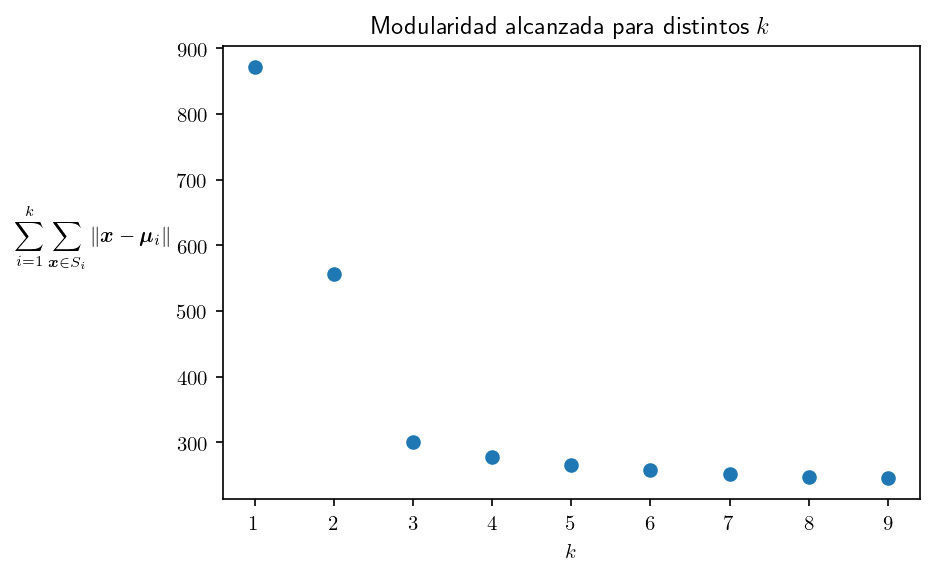

In [12]:
plt.figure(dpi=150)
plt.scatter(list(range(1,k+1)), last_modularity_achieved)
plt.xlabel("$k$")
plt.ylabel(r'$$\sum_{i=1}^k \sum_{\mathbold{x}\in S_i} \left \| '
           r'\mathbold{x} - \mathbold{\mu}_i \right \| $$', rotation=0, labelpad=40)
plt.title("Modularidad alcanzada para distintos $k$")

### Clustering espectral


In [13]:
from sklearn import cluster, datasets, mixture

XY, classes = datasets.make_moons(n_samples=3*N, noise=.05)

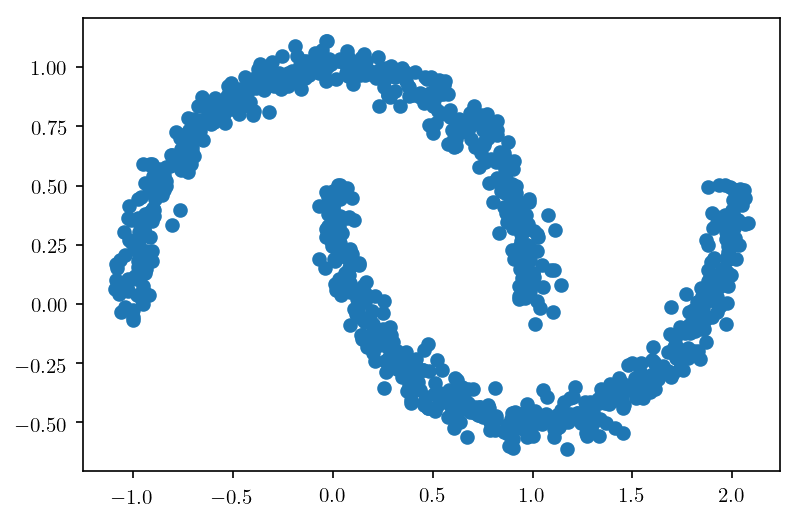

In [14]:
plt.figure(dpi=150)
plt.scatter(XY[:,0], XY[:,1])

In [ ]:
np.where(np.isclose(classes, 1))[0].min()

In [ ]:
np.where(np.isclose(classes, 0))[0].min()

/Users/ak/code/datos/datos-clustering/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ak/code/datos/datos-clustering/env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


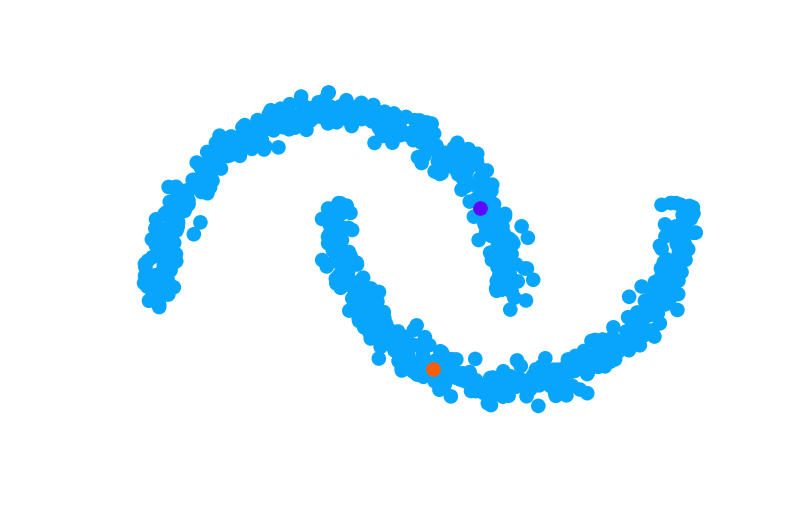

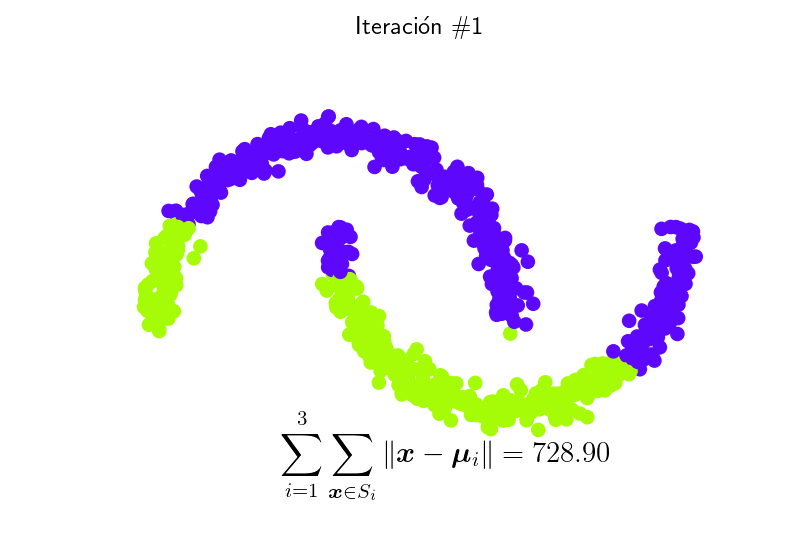

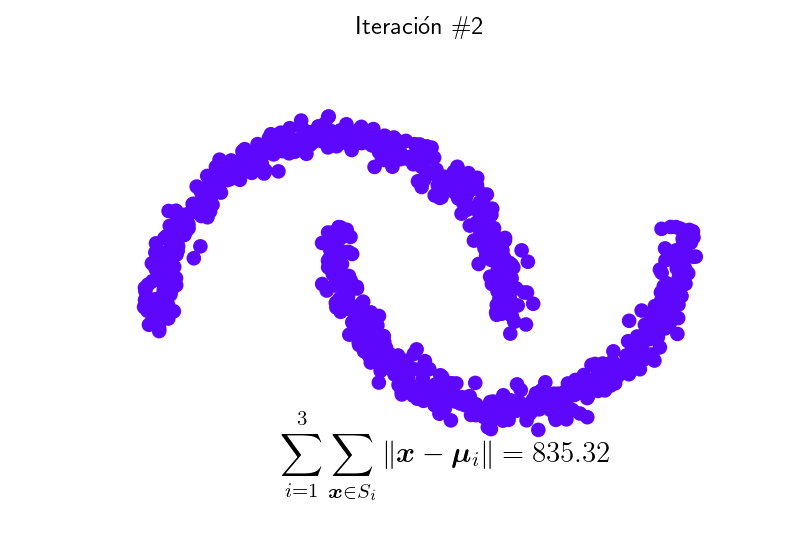

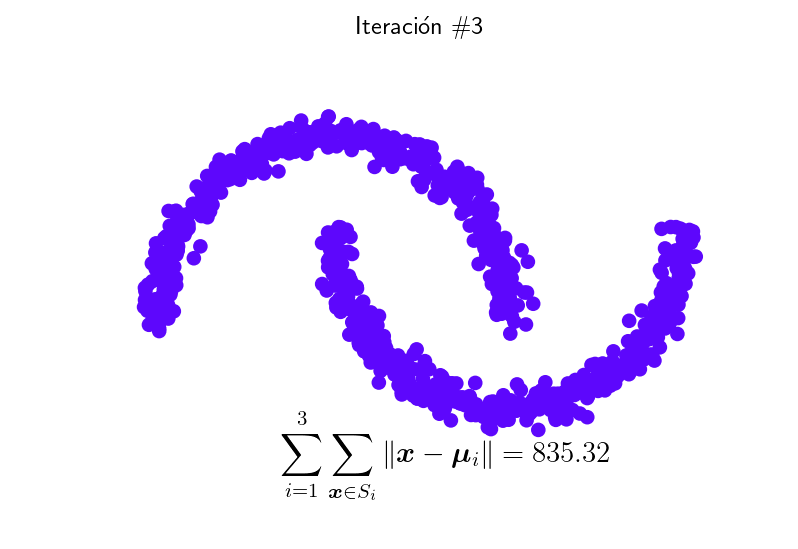

In [16]:
# Ayudamos un poquito: damos los índices de puntos en clases distintas
cluster_elements = [
    [np.where(np.isclose(classes, 0))[0].min()],
    [np.where(np.isclose(classes, 1))[0].min()]
]
colors = get_point_colors(cluster_elements)
plot_clustering(XY[:,0], XY[:,1], colors, lims=((-1.5,2.5),(-1,1.5)))

for it in range(3):
    
    cluster_means = get_cluster_means(cluster_elements, XY[:,0], XY[:,1])
    
    colors = [get_closest_cluster(cluster_means, x, y)  for x, y in XY]
    cluster_elements = construct_cluster_elements(colors)
    modularity = calculate_modularity(cluster_elements, XY[:,0], XY[:,1])    
    
    plot_clustering(XY[:,0], XY[:,1], colors,  f"{modularity:.2f}", it=str(it+1), lims=((-1.5,2.5),(-1,1.5)))

In [17]:
from sklearn.manifold import SpectralEmbedding
XY_red = SpectralEmbedding().fit_transform(XY)

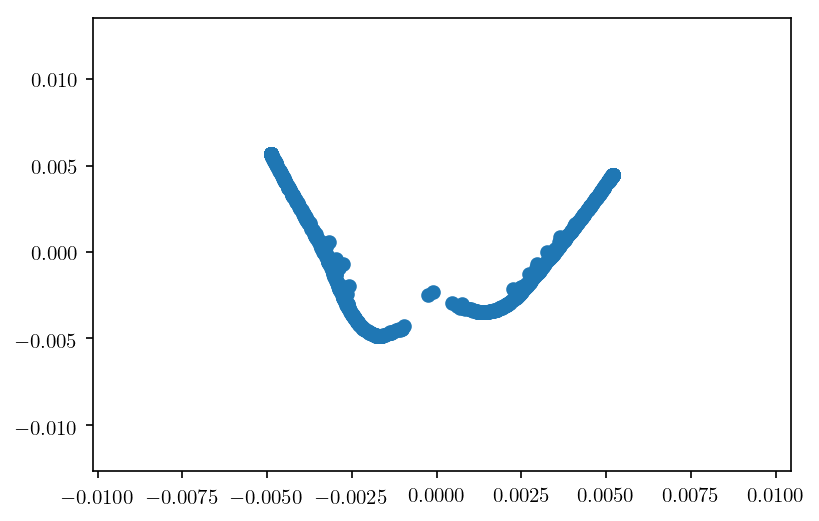

In [18]:
plt.figure(dpi=150)
plt.scatter(XY_red[:,0], XY_red[:, 1])

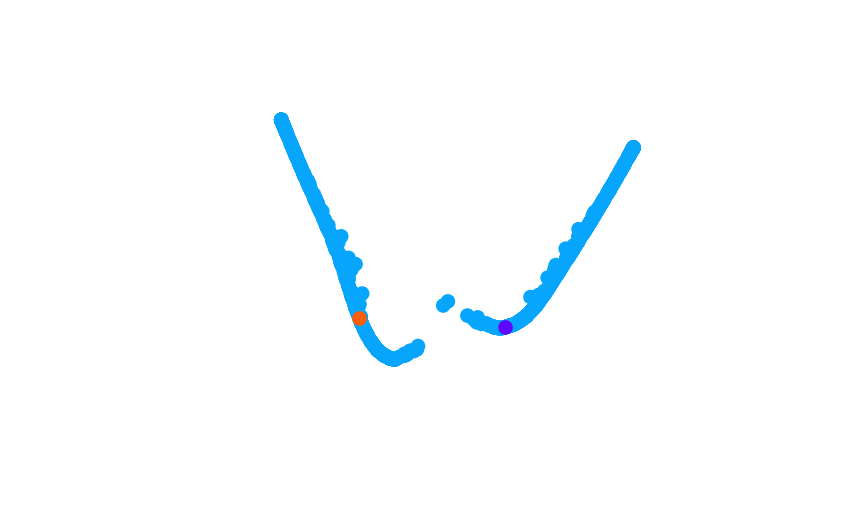

In [19]:
cluster_elements = [
    [np.where(np.isclose(classes, 0))[0].min()],
    [np.where(np.isclose(classes, 1))[0].min()]
]
colors = get_point_colors(cluster_elements)
plot_clustering(XY_red[:,0], XY_red[:,1], colors, lims=((-0.01, 0.01), (-0.01, 0.01)))

CPU times: user 127 µs, sys: 5 µs, total: 132 µs
Wall time: 138 µs
CPU times: user 42.2 ms, sys: 3.86 ms, total: 46.1 ms
Wall time: 45.1 ms
CPU times: user 176 µs, sys: 9 µs, total: 185 µs
Wall time: 190 µs
CPU times: user 1.53 ms, sys: 421 µs, total: 1.95 ms
Wall time: 1.7 ms
CPU times: user 23.8 ms, sys: 3.03 ms, total: 26.8 ms
Wall time: 23.6 ms
CPU times: user 1.56 ms, sys: 358 µs, total: 1.92 ms
Wall time: 964 µs
CPU times: user 38.6 ms, sys: 13.6 ms, total: 52.2 ms
Wall time: 25.4 ms


/Users/ak/code/datos/datos-clustering/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ak/code/datos/datos-clustering/env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


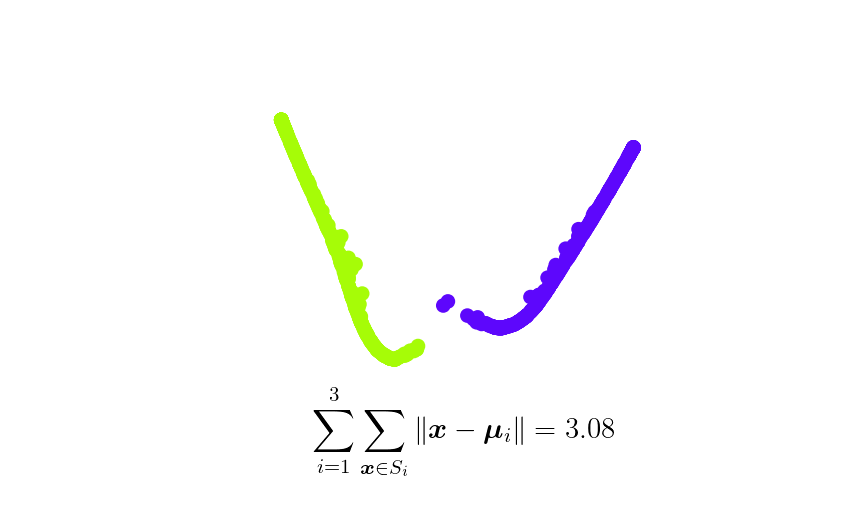

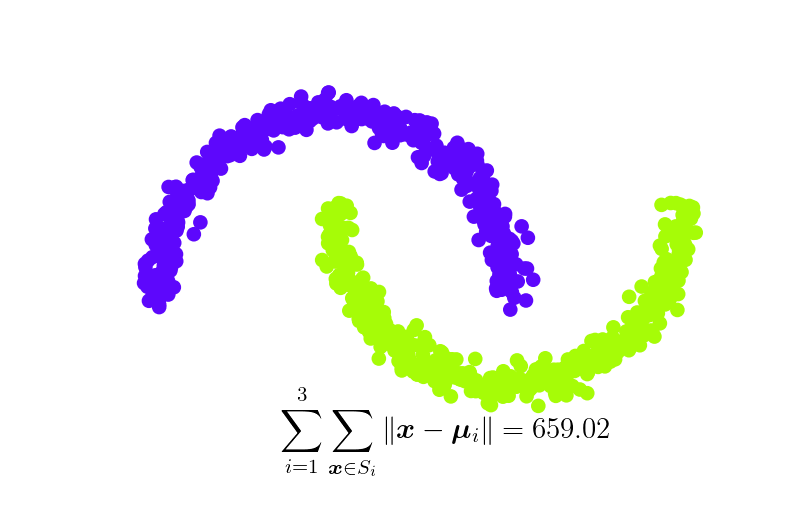

In [20]:
%time cluster_means = get_cluster_means(cluster_elements, XY_red[:,0], XY_red[:,1])

%time colors = [get_closest_cluster(cluster_means, x, y)  for x, y in XY_red]
%time cluster_elements = construct_cluster_elements(colors)
# En el espacio transformado
%time modularity = calculate_modularity(cluster_elements, XY_red[:,0], XY_red[:,1])    
%time plot_clustering(XY_red[:,0], XY_red[:,1], colors, f"{modularity:.2f}", lims=((-0.01, 0.01), (-0.01, 0.01)))
#%time plot_clustering(XY_red[:,0], XY_red[:,1], colors, lims=((-1.5, 1), (-1.5, 1.5)))
# En el espacio original
%time modularity = calculate_modularity(cluster_elements, XY[:,0], XY[:,1])    
%time plot_clustering(XY[:,0], XY[:,1], colors, f"{modularity:.2f}", lims=((-1.5, 2.5), (-1, 1.5)))